In [7]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from iqx import *
#IBMQ.save_account('our token was here')


# Loading your IBM Q account(s)
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2021-01-19 16:21:15,936: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-01-19 16:21:16,134: Credentials are already in use. The existing account in the session will be replaced.


In [8]:
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.finance.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [45]:
# set number of assets (= number of qubits)
num_assets = 8

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks,
                 start=datetime.datetime(2016,1,1),
                 end=datetime.datetime(2016,1,30))
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [46]:
print("MU expected return", mu)
print("SIGMA is covariance", sigma)
print("Stock tickers", stocks)

MU expected return [-0.00210202  0.00371714 -0.00309245 -0.00503582  0.04343306 -0.00144328
 -0.00107936  0.00236301]
SIGMA is covariance [[ 4.94330487e-04 -6.06864962e-05  3.41791216e-04 -1.36112845e-05
   4.71570217e-04  1.42888524e-04  1.82499475e-05 -5.80072838e-05]
 [-6.06864962e-05  9.64218311e-05 -1.06295887e-05  2.25611802e-05
  -4.59743646e-05  1.38403908e-04  1.41609610e-05  1.25620842e-05]
 [ 3.41791216e-04 -1.06295887e-05  3.09369384e-03  8.75057189e-06
   7.33279024e-05  5.89360215e-04 -4.89845115e-06 -8.81753047e-05]
 [-1.36112845e-05  2.25611802e-05  8.75057189e-06  2.37297805e-04
  -2.44364618e-04  5.47295431e-05  2.57209927e-05  2.02449043e-05]
 [ 4.71570217e-04 -4.59743646e-05  7.33279024e-05 -2.44364618e-04
   2.31243167e-02  1.95456163e-03 -6.41310780e-04 -1.38682505e-04]
 [ 1.42888524e-04  1.38403908e-04  5.89360215e-04  5.47295431e-05
   1.95456163e-03  3.25979314e-03 -4.36681928e-05 -3.35918676e-05]
 [ 1.82499475e-05  1.41609610e-05 -4.89845115e-06  2.57209927e-0

print the covariance terms


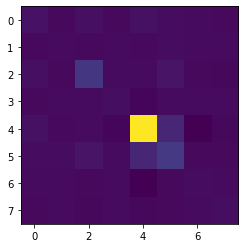

In [47]:
# plot sigma
print("print the covariance terms")
plt.imshow(sigma, interpolation='nearest')
plt.show()

In [48]:
q = 2.0                   # set risk factor
budget = num_assets // 2  # set budget - this is floor division
penalty = num_assets      # set parameter to scale the budget penalty term

qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)
# qubitOp is used to run the quantum algorithm, and offset not sure yet.

In [49]:
print("budget", budget, "penalty", penalty, "qubitOp", qubitOp, "offset", offset)

budget 4 penalty 8 qubitOp Representation: paulis, qubits: 8, size: 36 offset 16.014870556218522


In [50]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [51]:
# This uses eigenvalues using classical methods

exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
result = exact_eigensolver.run()

print_result(result)
print("Results are stocks 2, 5, 7, 8")

Optimal: selection [0 1 0 0 1 0 1 1], value -0.0042

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 1 0 1 1]	-0.0042		1.0000
[1 1 1 1 1 1 1 1]	128.0348		0.0000
[1 1 1 1 1 1 0 0]	32.0388		0.0000
[0 0 1 1 1 0 1 0]	0.0158		0.0000
[1 1 0 1 1 0 1 0]	8.0074		0.0000
[0 1 0 1 1 0 1 0]	0.0026		0.0000
[1 0 0 1 1 0 1 0]	0.0112		0.0000
[0 0 0 1 1 0 1 0]	8.0062		0.0000
[1 1 1 0 1 0 1 0]	8.0136		0.0000
[0 1 1 0 1 0 1 0]	0.0074		0.0000
[1 0 1 0 1 0 1 0]	0.0175		0.0000
[0 0 1 0 1 0 1 0]	8.0111		0.0000
[1 1 0 0 1 0 1 0]	0.0027		0.0000
[0 1 0 0 1 0 1 0]	7.9979		0.0000
[1 0 0 0 1 0 1 0]	8.0066		0.0000
[0 0 0 0 1 0 1 0]	32.0016		0.0000
[1 1 1 1 0 0 1 0]	8.0170		0.0000
[0 1 1 1 0 0 1 0]	0.0128		0.0000
[1 0 1 1 0 0 1 0]	0.0207		0.0000
[0 0 1 1 0 0 1 0]	8.0162		0.0000
[1 1 0 1 0 0 1 0]	0.0064		0.0000
[0 1 0 1 0 0 1 0]	8.0036		0.0000
[1 0 0 1 0 0 1 0]	8.0100		0.0000
[0 0 0 1 0 0 1 0]	32.0069		0.0000
[1 1 1 0 0 0 1 0

In [52]:
# This is using VQE
backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=1000)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

print_result(result)

print("the VQE method only gave us the right answer one time, seed 50, maxiter 1000")
print("VQE needed a higher risk factor, and more separation, to find the best answer. Risk = 2.0")
print("8 assets - best answer not found with probability > 0")

Optimal: selection [0. 0. 0. 0. 1. 1. 1. 1.], value 0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 1 1 1 1]	0.0149		0.2733
[0 1 0 1 1 0 0 1]	0.0015		0.2705
[0 0 1 0 1 1 1 0]	0.0291		0.1195
[0 1 1 1 1 0 0 0]	0.0133		0.1186
[1 1 1 1 0 0 0 0]	0.0155		0.0771
[1 0 1 0 0 1 1 0]	0.0258		0.0746
[1 1 0 1 0 0 0 1]	0.0029		0.0338
[1 0 0 0 0 1 1 1]	0.0108		0.0326
[1 1 0 1 1 0 0 1]	8.0059		0.0000
[0 0 1 0 0 1 1 0]	8.0207		0.0000
[0 1 0 1 0 0 0 1]	8.0004		0.0000
[0 0 0 0 0 1 1 1]	8.0073		0.0000
[1 0 0 0 1 1 1 1]	8.0202		0.0000
[1 0 1 0 1 1 1 0]	8.0361		0.0000
[1 1 1 1 1 0 0 0]	8.0193		0.0000
[0 1 1 1 0 0 0 0]	8.0113		0.0000
[0 0 0 1 1 1 1 1]	8.0198		0.0000
[0 1 0 0 1 1 1 1]	8.0118		0.0000
[0 1 1 0 1 0 0 0]	8.0086		0.0000
[0 0 1 1 1 0 0 0]	8.0170		0.0000
[1 0 1 1 0 0 0 0]	8.0192		0.0000
[0 0 0 0 1 1 1 0]	8.0172		0.0000
[0 0 0 1 1 0 0 1]	8.0051		0.0000
[1 1 1 0 0 0 0 0]	8.0099		0.0000
[0 1 1 0 1 1 1 

In [53]:
# Running QAOA 
backend = Aer.get_backend('statevector_simulator')
seed = 100

cobyla = COBYLA()
cobyla.set_options(maxiter=1000)
qaoa = QAOA(qubitOp, cobyla, 3)

qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = qaoa.run(quantum_instance)

print_result(result)

print("This method finds six answers to be equally best")
print("Setting penalty = 1.0 gave us the best portfolio, still 1/6")
print("This has no variation - same answer every time - not probabilistic")
print("QAOA risk = 2.0, gave the best answer but with a slightly lower probability")
print("QAOA works with 8 assets - probability same but it found the best answer on top")

Optimal: selection [0. 1. 0. 0. 1. 0. 1. 1.], value -0.0042

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 1 0 1 1]	-0.0042		0.0144
[0 1 0 1 1 0 0 1]	0.0015		0.0144
[1 1 0 0 1 0 0 1]	0.0013		0.0144
[1 1 0 0 0 0 1 1]	-0.0010		0.0144
[0 1 0 1 1 0 1 0]	0.0026		0.0144
[1 1 0 0 1 0 1 0]	0.0027		0.0144
[0 0 0 1 1 0 1 1]	0.0041		0.0143
[1 0 0 0 1 0 1 1]	0.0042		0.0143
[1 1 0 0 0 1 0 1]	0.0063		0.0143
[0 1 0 0 0 1 1 1]	0.0045		0.0143
[1 1 0 1 0 0 0 1]	0.0029		0.0143
[0 1 1 0 1 0 0 1]	0.0060		0.0143
[0 1 1 0 1 0 1 0]	0.0074		0.0143
[0 1 0 1 0 0 1 1]	0.0021		0.0143
[0 0 1 0 1 0 1 1]	0.0086		0.0143
[0 1 1 0 0 0 1 1]	0.0051		0.0143
[1 1 0 1 1 0 0 0]	0.0084		0.0143
[1 1 0 0 0 1 1 0]	0.0097		0.0143
[1 1 1 0 0 0 0 1]	0.0076		0.0143
[0 1 0 1 0 1 0 1]	0.0090		0.0143
[1 1 0 1 0 0 1 0]	0.0064		0.0143
[1 0 0 0 0 1 1 1]	0.0108		0.0143
[1 0 0 1 1 0 0 1]	0.0097		0.0143
[1 0 0 1 1 0 1 0]	0.0112		0.0143
[0 1 1 1 0 0

In [58]:
# Running the quantum simulator
# Max experiments is 32, max shots is 8192 and 32 qubits
backend = Aer.get_backend('qasm_simulator')
seed = 100

cobyla = COBYLA()
cobyla.set_options(maxiter=1000)
qaoa = QAOA(qubitOp, cobyla, 3)

qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = qaoa.run(quantum_instance)
print(result)
print_result(result)

print("This one did not find the best answer, but it did find an answer.  Errors on the print-out print_result statement")

{'optimal_parameters': {Parameter(θ[0]): 0.0, Parameter(θ[1]): 0.0, Parameter(θ[2]): 0.0, Parameter(θ[3]): 0.0, Parameter(θ[4]): 0.0, Parameter(θ[5]): 0.0}, 'optimal_point': array([0., 0., 0., 0., 0., 0.]), 'optimal_value': 0.17969937428623994, 'optimizer_evals': 37, 'optimizer_time': 33.93538856506348, 'eigenvalue': (0.17969937428623994+0j), 'eigenstate': {'00000000': 7, '00000001': 5, '00010000': 3, '00010001': 3, '00010010': 4, '00010011': 6, '00010100': 6, '00010101': 3, '00010110': 6, '00010111': 4, '00011000': 2, '00011001': 3, '00011010': 4, '00011011': 5, '00011100': 2, '00011101': 1, '00011110': 5, '00011111': 5, '00000010': 3, '00100000': 4, '00100001': 1, '00100010': 6, '00100011': 2, '00100100': 8, '00100101': 4, '00100110': 7, '00100111': 3, '00101000': 7, '00101001': 8, '00101010': 7, '00101011': 5, '00101100': 3, '00101101': 5, '00101110': 2, '00101111': 4, '00000011': 2, '00110000': 9, '00110001': 3, '00110010': 6, '00110011': 2, '00110100': 2, '00110101': 6, '00110110'

In [ ]:
# Running the largest IBM Quantum computer we have access to - 16 qubits melbourne

provider = IBMQ.get_provider('ibm-q')
backend = provider.get_backend('ibmq_16_melbourne')
seed = 100

cobyla = COBYLA()
cobyla.set_options(maxiter=1000)
qaoa = QAOA(qubitOp, cobyla, 3)

qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = qaoa.run(quantum_instance)
print(result)
print_result(result)

print("This one did not find the best answer, but it did find an answer.  Errors on the print-out print_result statement")

In [ ]:
# Information on the solver we just used
backend.properties().backend_name
backend.properties().backend_version
backend.properties().last_update_date
backend.properties().qubits
backend.properties().gates

In [ ]:
# Running the largest IBM Quantum computer we have access to - 16 qubits melbourne

provider = IBMQ.get_provider('ibm-q')
backend = provider.get_backend('ibmq_athens')
seed = 100

cobyla = COBYLA()
cobyla.set_options(maxiter=1000)
qaoa = QAOA(qubitOp, cobyla, 3)

qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = qaoa.run(quantum_instance)
print(result)
print_result(result)

print("This one did not find the best answer, but it did find an answer.  Errors on the print-out print_result statement")

In [ ]:
# Information on the solver we just used
backend.properties().backend_name
backend.properties().backend_version
backend.properties().last_update_date
backend.properties().qubits
backend.properties().gates

In [29]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright